In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

/var/folders/vx/lz_s92194473v0lcw_034qq40000gn/T/ipykernel_10681/131167381.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site

In [3]:
dim_reduced_df = pd.read_csv('../data/feature-engineered/df_2_reduced.csv')

In [4]:
# -----------------------------
# CONFIG
# -----------------------------
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

recession_targets = [
    'recession_probability', '1_month_recession_probability',
    '3_month_recession_probability', '6_month_recession_probability'
]

In [5]:
# -----------------------------
# DATA SPLIT (reuse your function)
# -----------------------------
def prepare_data_split(df, date_col='date', split_year=2020):
    df[date_col] = pd.to_datetime(df[date_col])
    df_sorted = df.sort_values(date_col).reset_index(drop=True)
    train_data = df_sorted[df_sorted[date_col].dt.year < split_year].copy()
    test_data = df_sorted[df_sorted[date_col].dt.year >= split_year].copy()
    print(f"Training: {len(train_data)} rows | Testing: {len(test_data)} rows")
    return train_data, test_data

# -----------------------------
# Create sequences for LSTM
# -----------------------------
def create_sequences(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# -----------------------------
# LSTM Forecast Function
# -----------------------------
def forecast_with_lstm(train_df, test_df, target, exog_cols=None, epochs=500, batch_size=16, time_steps=5):
    print(f"\n{'='*50}")
    print(f"LSTM Forecasting: {target}")
    print(f"{'='*50}")

    # Prepare feature sets
    features = exog_cols if exog_cols else []
    X_train = train_df[features].values if features else np.arange(len(train_df)).reshape(-1, 1)
    y_train = train_df[target].values
    X_test = test_df[features].values if features else np.arange(len(test_df)).reshape(-1, 1)
    y_test = test_df[target].values

    # Clean missing/infinite values
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
    y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
    y_test = np.nan_to_num(y_test, nan=0.0, posinf=0.0, neginf=0.0)

    # Scaling
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))

    # Sequence generation for LSTM
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

    # Reshape for LSTM input
    X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2]))
    X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2]))

    # -----------------------------
    # Build LSTM Model
    # -----------------------------
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(time_steps, X_train_seq.shape[2]), return_sequences=False),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Train model
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    # Predict
    y_pred_scaled = model.predict(X_test_seq).flatten()
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Align actuals for the same length as predictions
    y_test = y_test[time_steps:]

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(np.abs(y_test), 1e-8))) * 100

    print(f"📊 Results: MAE={mae:.4f}, RMSE={rmse:.4f}, MAPE={mape:.2f}%")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(test_df['date'][time_steps:], y_test, label='Actual', color='blue')
    plt.plot(test_df['date'][time_steps:], y_pred, label='Forecast', color='red')
    plt.title(f"LSTM Forecast vs Actual - {target}")
    plt.legend()
    plt.show()

    return model, y_pred, mae, rmse, mape

# -----------------------------
# RUN PIPELINE
# -----------------------------
def run_lstm_pipeline(df, financial_indicators, include_exog=True, time_steps=5):
    train_data, test_data = prepare_data_split(df)
    all_results = {}

    exog_cols = None
    if include_exog:
        exog_cols = [col for col in df.columns if col not in financial_indicators + recession_targets + ['date']]
        print(f"Using {len(exog_cols)} exogenous features")

    for indicator in financial_indicators:
        if indicator not in df.columns:
            print(f"⚠️ {indicator} not found")
            continue

        model, y_pred, mae, rmse, mape = forecast_with_lstm(
            train_data, test_data, indicator,
            exog_cols=exog_cols, time_steps=time_steps
        )
        all_results[indicator] = {
            'model': model,
            'forecast': y_pred,
            'mae': mae,
            'rmse': rmse,
            'mape': mape
        }

    return all_results


Training: 635 rows | Testing: 65 rows
Using 35 exogenous features

LSTM Forecasting: 1_year_rate


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
📊 Results: MAE=5.4128, RMSE=6.0116, MAPE=814.82%


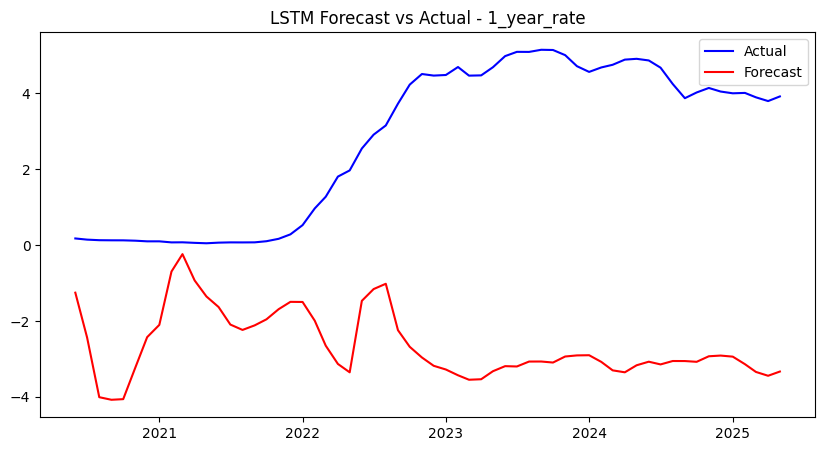


LSTM Forecasting: 3_months_rate


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
📊 Results: MAE=1.6860, RMSE=1.9210, MAPE=713.59%


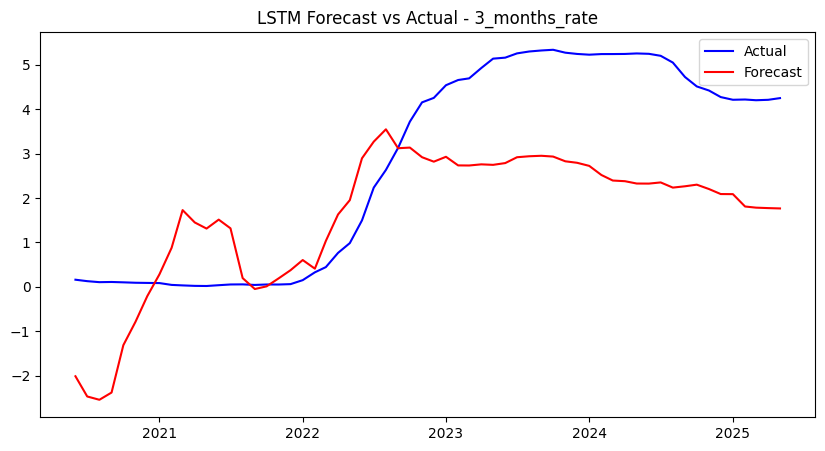


LSTM Forecasting: 6_months_rate


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x325e78d60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
📊 Results: MAE=2.2758, RMSE=2.4129, MAPE=1023.88%


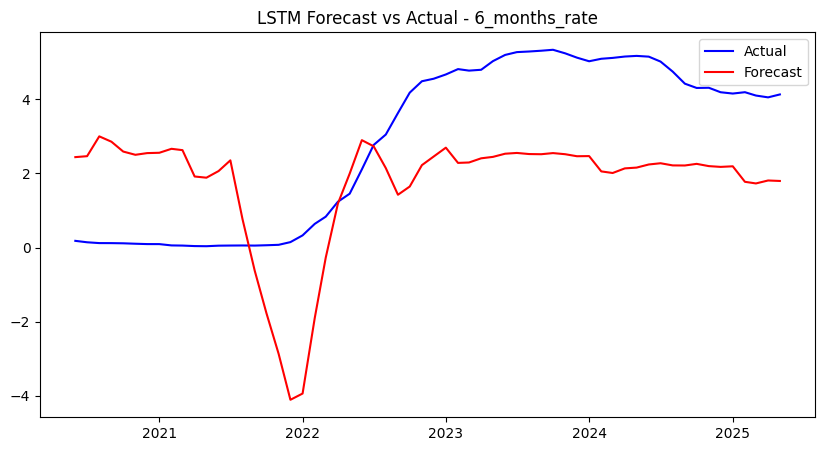


LSTM Forecasting: CPI


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
📊 Results: MAE=12.7477, RMSE=14.9667, MAPE=4.34%


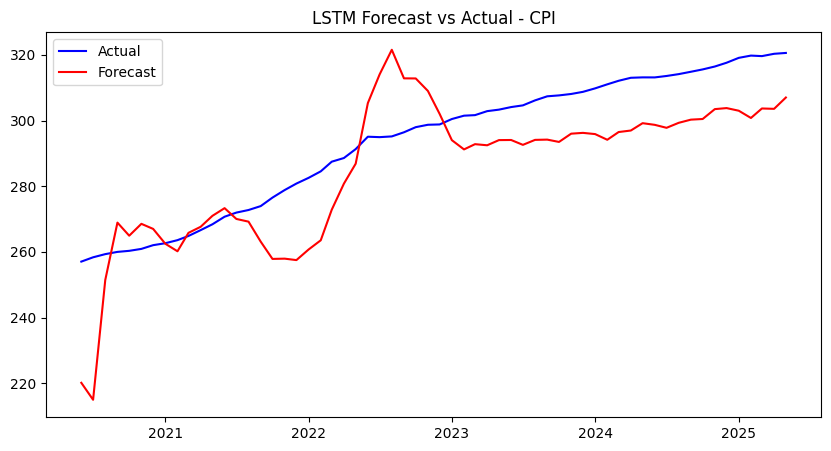


LSTM Forecasting: INDPRO


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
📊 Results: MAE=16.3110, RMSE=17.1618, MAPE=16.00%


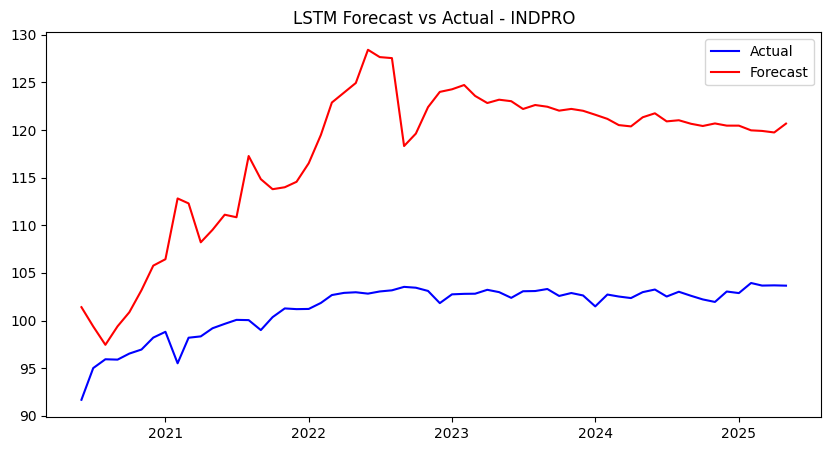


LSTM Forecasting: 10_year_rate


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
📊 Results: MAE=1.1251, RMSE=1.5067, MAPE=81.62%


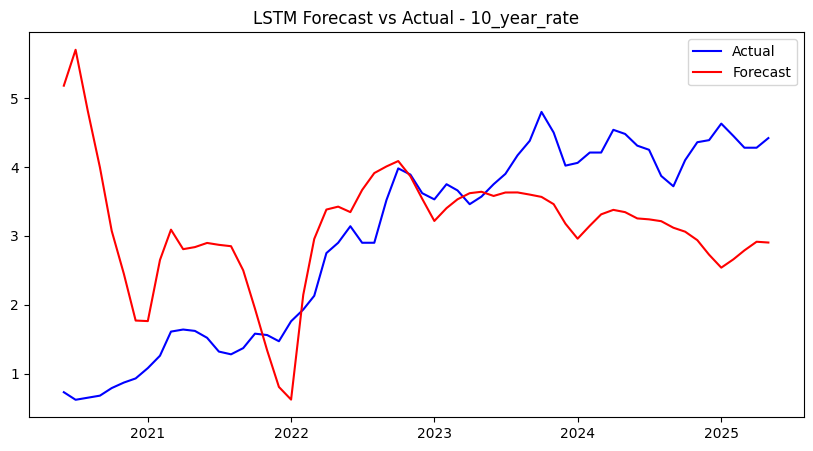


LSTM Forecasting: share_price


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
📊 Results: MAE=0.6418, RMSE=0.6963, MAPE=9.57%


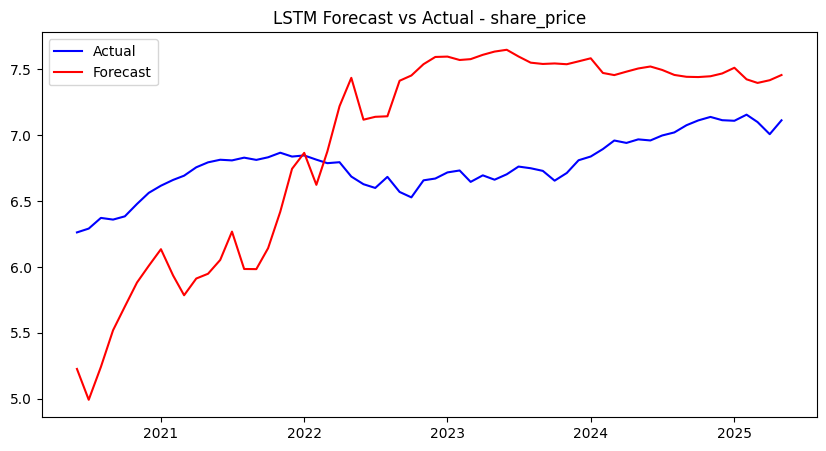


LSTM Forecasting: unemployment_rate


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
📊 Results: MAE=0.5512, RMSE=0.7849, MAPE=11.44%


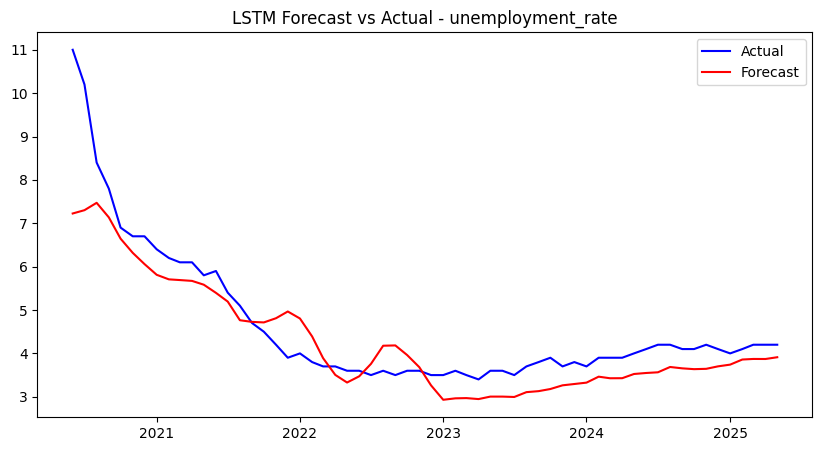


LSTM Forecasting: PPI


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
📊 Results: MAE=59.9910, RMSE=68.3823, MAPE=12.07%


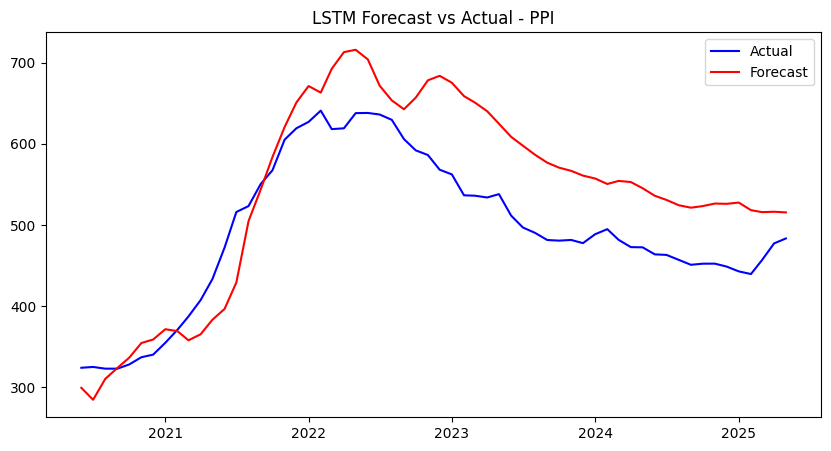


LSTM Forecasting: OECD_CLI_index


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
📊 Results: MAE=1.9161, RMSE=2.2401, MAPE=1.93%


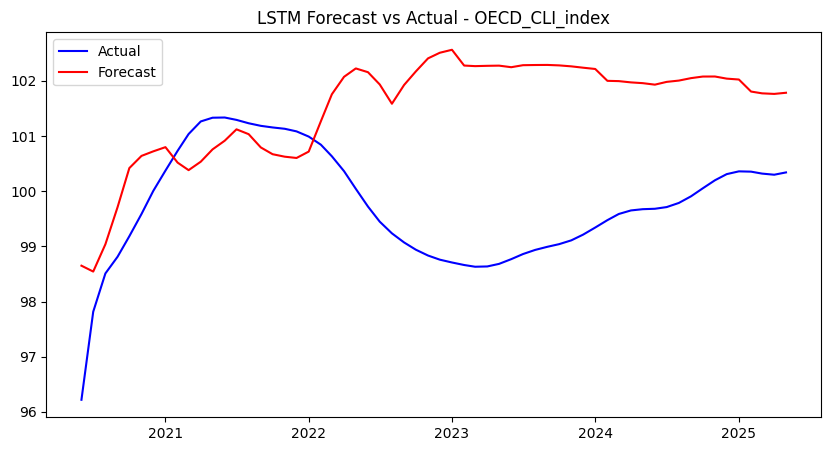


LSTM Forecasting: CSI_index


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
📊 Results: MAE=21.1212, RMSE=23.5991, MAPE=33.16%


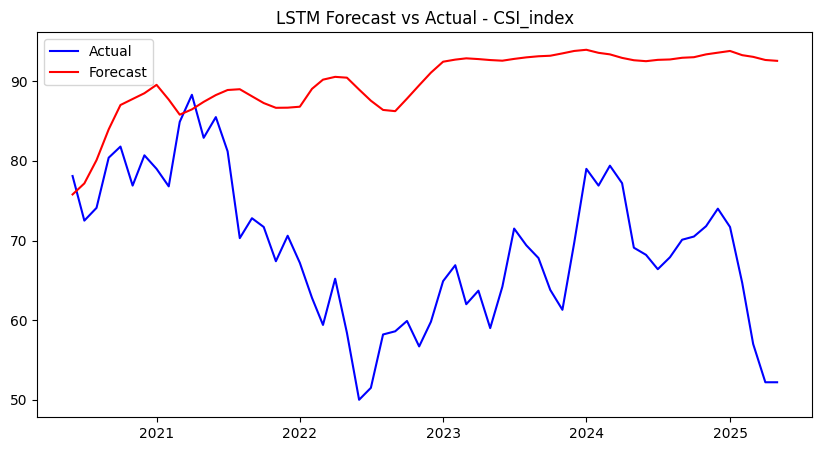


LSTM Forecasting: gdp_per_capita


/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
📊 Results: MAE=3928.2858, RMSE=9823.5483, MAPE=11822289062504.19%


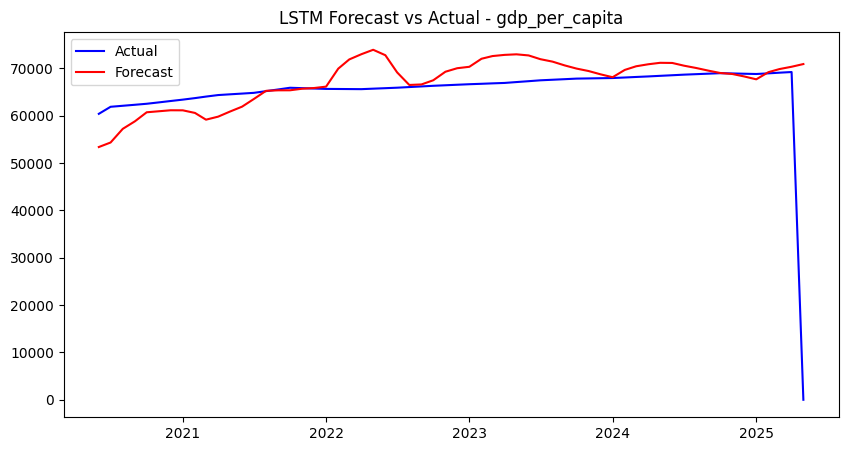

In [6]:
results = run_lstm_pipeline(dim_reduced_df, financial_indicators, include_exog=True)